<a href="https://colab.research.google.com/github/nchadburn/Stat598-FinalProject/blob/main/MLPA%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# finanance data
import yfinance as yf

#visualization
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

#date manipulation
from datetime import datetime
import pandas as pd
import numpy as np

#Autoreg and Arima models
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor


# statstical testing, plotting and decompositions
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

from scipy import stats

In [112]:
start_date = '2020-06-01'
end_date = '2023-12-01'
etf_ticker = 'MLPA'
moving_average_list = []
etf_tickers_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/mlpa_full-holdings.csv"
crude_oil_stock_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/crude%20oil%20spot%20price.csv"



https://www.eia.gov/dnav/pet/pet_pri_spt_s1_d.htm
pulled crude price oil from this


In [34]:
df_holdings = pd.read_csv(etf_tickers_url)
df_holdings = df_holdings[(df_holdings['Name'] != 'OTHER PAYABLE & RECEIVABLES') & (df_holdings['Name'] != 'CASH')]

df_holdings[f'Market Value ($)'] = df_holdings[f'Market Value ($)'].str.replace(',', '').astype(float)
total_market_value = df_holdings[f'Market Value ($)'].sum()
df_holdings['Percentage Holdings By Value'] = (df_holdings[f'Market Value ($)'] / total_market_value)
df_holdings

,% of Net Assets,Ticker,Name,SEDOL,Market Price ($),Shares Held,Market Value ($),Percentage Holdings By Value
0,20.87,ET,ENERGY TRANSFER LP,B0WHXD2,13.33,"22,735,436.84",3.030634e+08,2.004323e-01
1,13.76,EPD,ENTERPRISE PRODU,2285388,26.25,"7,611,951.00",1.998137e+08,1.321477e-01
2,12.17,MPLX,MPLX LP,B847R56,35.87,"4,925,004.00",1.766599e+08,1.168348e-01
3,10.80,PAA,PLAINS ALL AMER,2311960,14.95,"10,486,658.00",1.567755e+08,1.036842e-01
4,10.32,WES,WESTERN MIDSTREA,BJ552C8,28.24,"5,303,028.00",1.497575e+08,9.904279e-02
5,9.47,ENLC,ENLINK MIDSTREAM LLC,BJTNDQ9,12.81,"10,731,120.00",1.374656e+08,9.091352e-02
6,8.26,CQP,CHENIERE ENERGY,B1VNH36,59.30,"2,023,409.00",1.199882e+08,7.935470e-02
7,6.53,NS,NUSTAR ENERGY LP,2738804,19.00,"4,991,913.00",9.484635e+07,6.272705e-02
8,5.91,HESM,HESS MIDSTREAM-A,BKPK695,30.70,"2,795,220.00",8.581325e+07,5.675298e-02
9,4.53,GEL,GENESIS ENERGY L.P.,2372257,12.32,"5,334,251.00",6.571797e+07,4.346287e-02


In [74]:
df_crude_price = pd.read_csv(crude_oil_stock_url,usecols=[0, 1])

df_crude_price['Date'] = pd.to_datetime(df_crude_price['Date'], format='%b %d, %Y')
df_crude_price.set_index('Date', inplace=True)
df_crude_price.rename(columns={'WTI Barrell Spot Price':'Spot Price'}, inplace=True)

df_crude_price['Spot Price'] = df_crude_price['Spot Price'].fillna(method='ffill')



In [85]:

all_stocks_data = yf.download(etf_ticker, start=start_date, end=end_date)
#join spot price and etf
all_stocks_data['Ticker'] = etf_ticker
all_stocks_data.columns = [f'{etf_ticker}_{col}' if col not in ['Ticker', 'Date'] else col for col in all_stocks_data.columns]
all_stocks_data = all_stocks_data.join(df_crude_price, how='left')




[*********************100%%**********************]  1 of 1 completed


In [86]:
all_stocks_data

,MLPA_Open,MLPA_High,MLPA_Low,MLPA_Close,MLPA_Adj Close,MLPA_Volume,Ticker,Spot Price
Date,,,,,,,,
2020-06-01,29.770000,30.030001,29.270000,29.459999,21.973850,251400,MLPA,35.49
2020-06-02,29.790001,30.209999,29.570000,30.150000,22.488514,384200,MLPA,36.88
2020-06-03,30.280001,31.430000,30.280001,31.190001,23.264236,596100,MLPA,37.33
2020-06-04,30.940001,31.969999,30.900000,31.940001,23.823652,508200,MLPA,37.42
2020-06-05,32.910000,33.910000,32.910000,33.560001,25.031994,510700,MLPA,39.49
...,...,...,...,...,...,...,...,...
2023-11-24,45.310001,45.450001,45.029999,45.200001,45.200001,32500,MLPA,74.83
2023-11-27,45.250000,45.330002,45.009998,45.250000,45.250000,48900,MLPA,74.46
2023-11-28,45.250000,45.259998,44.799999,45.250000,45.250000,91800,MLPA,76.09


In [87]:
# load all tickers part of that etf
for ticker in df_holdings['Ticker']:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    percentage_holding = df_holdings.loc[df_holdings['Ticker'] == ticker, 'Percentage Holdings By Value'].iloc[0]
    all_stocks_data[f'{ticker}_Percent_Holding'] = percentage_holding
    stock_data.columns = [f'{ticker}_{col}' if col != 'Ticker' else col for col in stock_data.columns]

    all_stocks_data = all_stocks_data.join(stock_data, how='outer')

all_stocks_data.fillna(0, inplace=True)

sum_values = pd.Series(0, index=all_stocks_data.index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [88]:
#moving averages

for ma in moving_average_list:
  all_stocks_data[f'{etf_ticker}_MA_{ma}'] = all_stocks_data[f'{etf_ticker}_Close'].rolling(window=ma).mean()
  all_stocks_data[f'{etf_ticker}_STD_{ma}'] = all_stocks_data[f'{etf_ticker}_Close'].rolling(window=ma).std()

for ticker in df_holdings['Ticker']:
    for ma in moving_average_list:
        all_stocks_data[f'{ticker}_MA_{ma}'] = all_stocks_data[f'{ticker}_Close'].rolling(window=ma).mean()
        all_stocks_data[f'{ticker}_STD_{ma}'] = all_stocks_data[f'{ticker}_Close'].rolling(window=ma).std()

In [91]:
# does some weighted and sum values of all the stock prices in the etf
weighted_values = pd.Series(0, index=all_stocks_data.index)
sum_values = pd.Series(0, index=all_stocks_data.index)

for ticker in df_holdings['Ticker']:
    weighted_values += all_stocks_data[f'{ticker}_Close'] * all_stocks_data[f'{ticker}_Percent_Holding']
    sum_values += all_stocks_data[f'{ticker}_Close']


all_stocks_data['Weighted Stock Value'] = weighted_values
all_stocks_data['Sum Stock Value'] = sum_values

all_stocks_data[f'{etf_ticker}_Next_Close'] = all_stocks_data[f'{etf_ticker}_Close'].shift(-1)

all_stocks_data.reset_index(inplace=True)
all_stocks_data.tail()

,index,Date,MLPA_Open,MLPA_High,MLPA_Low,MLPA_Close,MLPA_Adj Close,MLPA_Volume,Ticker,Spot Price,...,USDP_Percent_Holding,USDP_Open,USDP_High,USDP_Low,USDP_Close,USDP_Adj Close,USDP_Volume,Weighted Stock Value,Sum Stock Value,MLPA_Next_Close
878,878,2023-11-24,45.310001,45.450001,45.029999,45.200001,45.200001,32500,MLPA,74.83,...,1.488047e-08,0.250,0.280,0.225,0.225,0.225,72000,25.016806,529.494997,45.250000
879,879,2023-11-27,45.250000,45.330002,45.009998,45.250000,45.250000,48900,MLPA,74.46,...,1.488047e-08,0.215,0.233,0.211,0.226,0.226,105500,24.955155,527.801000,45.250000
880,880,2023-11-28,45.250000,45.259998,44.799999,45.250000,45.250000,91800,MLPA,76.09,...,1.488047e-08,0.229,0.270,0.225,0.225,0.225,375600,25.002750,528.994998,45.500000
881,881,2023-11-29,45.320000,45.660000,45.090000,45.500000,45.500000,63700,MLPA,77.56,...,1.488047e-08,0.221,0.260,0.221,0.243,0.243,106300,25.287195,541.103003,46.119999
882,882,2023-11-30,45.540001,46.119999,45.400002,46.119999,46.119999,73000,MLPA,75.66,...,1.488047e-08,0.240,0.273,0.240,0.260,0.260,69200,25.661618,553.160002,NaN


Mean Squared Error: 1.1493224172395085


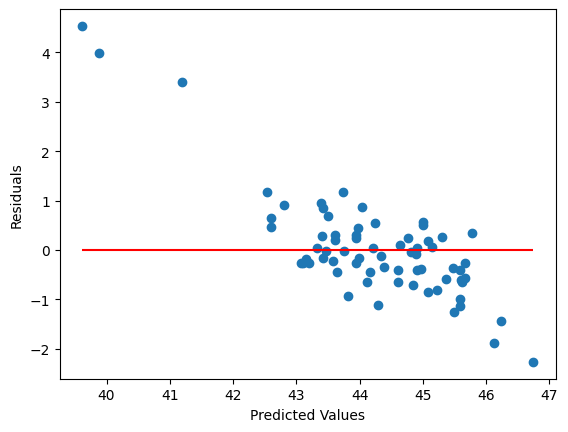

Shapiro-Wilk Test: ShapiroResult(statistic=0.8178101181983948, pvalue=8.624690650549383e-08)
Durbin-Watson statistic: 2.225235995485949
       feature           VIF
0   Spot Price   3938.383271
1     ET_Close  16189.174361
2    EPD_Close  32028.453265
3   MPLX_Close  34991.778602
4    PAA_Close  13085.190063
5    WES_Close  11535.181809
6   ENLC_Close  13826.049762
7    CQP_Close   8119.834680
8     NS_Close   3442.979608
9   HESM_Close   7414.174204
10   GEL_Close   1856.100283
11   DKL_Close   3376.867304
12   PSX_Close   4497.993318
13  MLPX_Close  41619.788109
14  CAPL_Close   4240.254370
15  SMLP_Close    543.684123
16   GPP_Close   1435.302692
17   NGL_Close   3710.626000
18  MMLP_Close    497.087804
19  SNMP_Close     53.689491
20  USDP_Close    228.355847


'MLPA_Next_Close = 37.2009 + (0.1754 * Spot Price) + (-1.3743 * ET_Close) + (-0.0657 * EPD_Close) + (-0.7628 * MPLX_Close) + (0.3801 * PAA_Close) + (-0.8718 * WES_Close) + (-0.2040 * ENLC_Close) + (-0.1477 * CQP_Close) + (0.5282 * NS_Close) + (0.0302 * HESM_Close) + (-0.0679 * GEL_Close) + (-0.0448 * DKL_Close) + (0.1209 * PSX_Close) + (1.1189 * MLPX_Close) + (0.3222 * CAPL_Close) + (0.2394 * SMLP_Close) + (-0.3394 * GPP_Close) + (-0.2973 * NGL_Close) + (-1.7454 * MMLP_Close) + (-0.4314 * SNMP_Close) + (-0.2866 * USDP_Close)'

In [113]:
feature_columns = [col for col in all_stocks_data.columns if ('_Close' in col or 'Spot' in col) and etf_ticker not in col]
features = all_stocks_data[feature_columns]
target = all_stocks_data[f'{etf_ticker}_Next_Close']

features = features[:-1]
target = target[:-1]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.8, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk Test:", shapiro_test)

dw_test = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw_test)

vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

print(vif_data)

coefficients = model.coef_
intercept = model.intercept_

linear_formula = f"{etf_ticker}_Next_Close = {intercept:.4f}"
for i, col in enumerate(feature_columns):
    linear_formula += f" + ({coefficients[i]:.4f} * {col})"

linear_formula



Shaprio - less than .05 so its not normally distrubted.
Durbin-Watson Stats is looking good. We are seeing alot of Variance Inflation Factor (VIF) issues with this data set.

In [114]:
# Applying logarithmic transformation and differencing to the data
df_log = np.log(all_stocks_data[feature_columns + [f'{etf_ticker}_Close']])
df_shift = df_log - df_log.shift(periods=1)

df_shift = df_shift.dropna()

features_shifted = df_shift[feature_columns]
target_shifted = df_shift[f'{etf_ticker}_Close']

X_train_shifted, X_test_shifted, y_train_shifted, y_test_shifted = train_test_split(
    features_shifted, target_shifted, test_size=0.8, random_state=0)



In [115]:

positive_data = all_stocks_data[feature_columns + [f'{etf_ticker}_Close']] > 0
if not positive_data.all().all():
    all_stocks_data = all_stocks_data[positive_data.all(axis=1)]


df_log = np.log(all_stocks_data[feature_columns + [f'{etf_ticker}_Close']])
df_shift = df_log - df_log.shift(periods=1)
df_shift = df_shift.replace([np.inf, -np.inf], np.nan).dropna()


features_shifted = df_shift[feature_columns]
target_shifted = df_shift[f'{etf_ticker}_Close']


X_train_shifted, X_test_shifted, y_train_shifted, y_test_shifted = train_test_split(
    features_shifted, target_shifted, test_size=0.8, random_state=0)

model_shifted = LinearRegression()
model_shifted.fit(X_train_shifted, y_train_shifted)

y_pred_shifted = model_shifted.predict(X_test_shifted)
mse_shifted = mean_squared_error(y_test_shifted, y_pred_shifted)

mse_shifted


4.491324501623271e-05

In [106]:

y_pred_log = model_shifted.predict(X_test_shifted)

y_pred_original_scale = np.exp(y_pred_log)

y_test_original_scale = np.exp(y_test_shifted)

mse_original_scale = mean_squared_error(y_test_original_scale, y_pred_original_scale)

mse_original_scale


4.465790219161065e-05